In [281]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fixed_point
import matplotlib.pyplot as plt
import pandas as pd

In [282]:
# Load Training Data

filename = "/home/smalani/Cybernetic_BioModel/optogenetic_model_fits/June152023Onwards/trainingData/SGy139_TimeCourse_Jun9_23.xlsx"
df_br1 = pd.read_excel(filename, sheet_name="Bioreactor1")
df_br2 = pd.read_excel(filename, sheet_name="Bioreactor2")

df_br1.head()

,BatchTime,Phase,GrowthRate
0,0.000000,0.05,0.022972
1,0.016667,0.05,0.043676
2,0.033333,0.05,0.043676
3,0.050000,0.05,0.061904
4,0.066667,0.05,0.061904


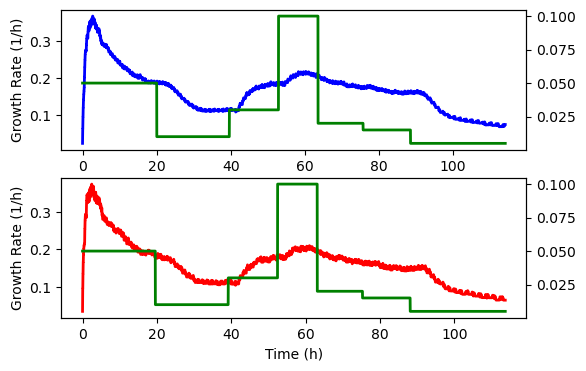

In [283]:
# Visualize Training Data

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(211)
ax.plot(df_br1["BatchTime"], df_br1["GrowthRate"], linewidth=2, color="blue", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br1["BatchTime"], df_br1["Phase"], linewidth=2, color="green", label="Bioreactor 1")

ax = fig.add_subplot(212)
ax.plot(df_br2["BatchTime"], df_br2["GrowthRate"], linewidth=2, color="red", label="Bioreactor 2")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br2["BatchTime"], df_br2["Phase"], linewidth=2, color="green", label="Bioreactor 2")

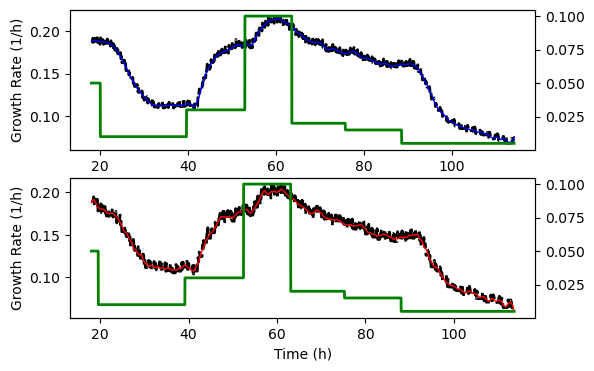

In [284]:
# Truncate and Smooth Data
from scipy.signal import savgol_filter

# Truncate data to remove initial lag phase
time_cutoff = 18
df_br1_trunc = df_br1[df_br1["BatchTime"] > time_cutoff].copy()
df_br2_trunc = df_br2[df_br2["BatchTime"] > time_cutoff].copy()

# Smooth data using Savitzky-Golay filter
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
# Parameters
window_size = 151
poly_order = 3
deriv = 0
df_br1_trunc["GrowthRateSmooth"] = savgol_filter(df_br1_trunc["GrowthRate"], window_size, poly_order, deriv=deriv)
df_br2_trunc["GrowthRateSmooth"] = savgol_filter(df_br2_trunc["GrowthRate"], window_size, poly_order, deriv=deriv)

# Visualize truncated and smoothed data
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(211)
ax.plot(df_br1_trunc["BatchTime"], df_br1_trunc["GrowthRate"], '--', linewidth=2, color="black", label="Bioreactor 1 (Raw)")
ax.plot(df_br1_trunc["BatchTime"], df_br1_trunc["GrowthRateSmooth"], linewidth=1, color="blue", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br1_trunc["BatchTime"], df_br1_trunc["Phase"], linewidth=2, color="green", label="Bioreactor 1")

ax = fig.add_subplot(212)
ax.plot(df_br2_trunc["BatchTime"], df_br2_trunc["GrowthRate"], '--', linewidth=2, color="black", label="Bioreactor 2 (Raw)")
ax.plot(df_br2_trunc["BatchTime"], df_br2_trunc["GrowthRateSmooth"], linewidth=1, color="red", label="Bioreactor 2")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br2_trunc["BatchTime"], df_br2_trunc["Phase"], linewidth=2, color="green", label="Bioreactor 2")

[0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.1]
[0.0734547580486065, 0.11449916164970078, 0.16115651184315924, 0.17368609162895002, 0.1835650140137684, 0.18798828591981112, 0.2066117976456574]
[0.0010881118139570098, 0.00017922013821686667, 0.0001351855672608787, 0.00023040634511450214, 0.0003416015420552834, 9.79051449885469e-05, 0.0003940932568776185]
[0.06350886004033417, 0.11409157907206488, 0.14736955059094883, 0.1629574775336532, 0.1785494072864605, 0.18371385974925505, 0.194438254015791]
[0.0020202843944336297, 0.0005138569688471562, 0.00021633159036764683, 0.0003193719741695719, 0.00022387115608396834, 0.0006227661336243767, 0.0002279725263584661]


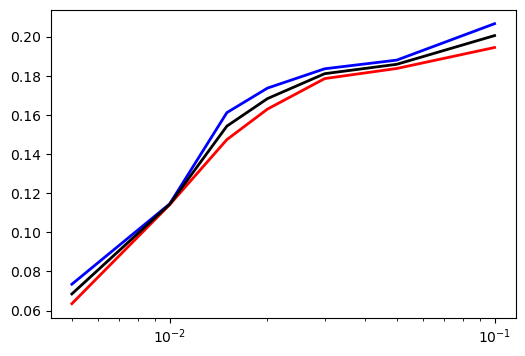

In [285]:
# Split dataframe by Phase

df_br1_trunc_grouped = df_br1_trunc.groupby("Phase")
df_br2_trunc_grouped = df_br2_trunc.groupby("Phase")

keys = list(df_br1_trunc_grouped.groups.keys())
print(keys)

mu_mean_br1 = []
mu_std_br1 = []
mu_mean_br2 = []
mu_std_br2 = []
mu_mean_overall = []
mu_std_overall = []

rangeme = 20

for key in keys:
    df = df_br1_trunc_grouped.get_group(key)
    mu_mean_br1.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    mu_std_br1.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())
    df = df_br2_trunc_grouped.get_group(key)
    mu_mean_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    mu_std_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())

    mu_mean_overall.append((mu_mean_br1[-1] + mu_mean_br2[-1])/2)
    mu_std_overall.append(np.sqrt(mu_std_br1[-1]**2 + mu_std_br2[-1]**2))
    

print(mu_mean_br1)
print(mu_std_br1)
print(mu_mean_br2)
print(mu_std_br2)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.semilogx(keys, mu_mean_br1, linewidth=2, color="blue", label="Bioreactor 1")
ax.semilogx(keys, mu_mean_br2, linewidth=2, color="red", label="Bioreactor 2")
ax.semilogx(keys, mu_mean_overall, linewidth=2, color="black", label="Overall")

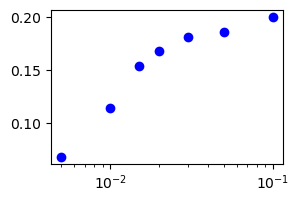

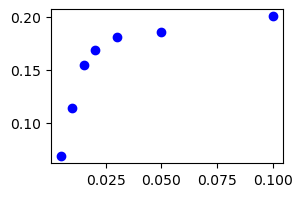

In [286]:
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
ax.semilogx(keys, mu_mean_overall, 'o', linewidth=2, color="blue", label="Bioreactor 1")

fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
ax.plot(keys, mu_mean_overall, 'o', linewidth=2, color="blue", label="Bioreactor 1")

In [287]:
# Load Training Data

filename = "/home/smalani/Cybernetic_BioModel/optogenetic_model_fits/June152023Onwards/trainingData/SGy139_ActDeAct_Mar1_23.xlsx"
df_br1_actdeact = pd.read_excel(filename, sheet_name="Bioreactor1")
df_br2_actdeact = pd.read_excel(filename, sheet_name="Bioreactor2")

df_br1_actdeact.head()

,BatchTime,Phase,GrowthRate
0,0.000000,Batch_10%_1,0.021140
1,0.016667,Batch_10%_1,0.040492
2,0.033333,Batch_10%_1,0.040492
3,0.050000,Batch_10%_1,0.057788
4,0.066667,Batch_10%_1,0.057788


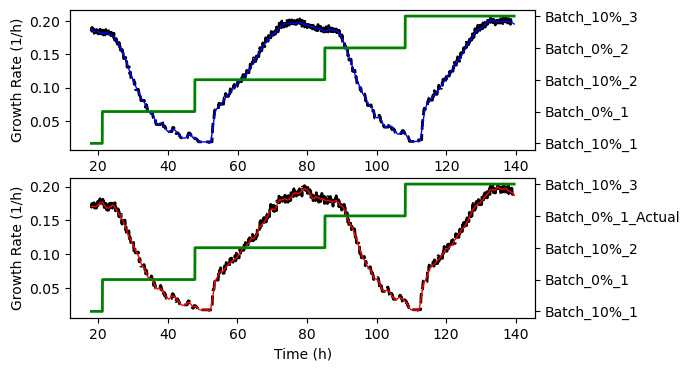

In [288]:
# Truncate and Smooth Data
from scipy.signal import savgol_filter

# Truncate data to remove initial lag phase
time_cutoff = 18
df_br1_trunc_actdeact = df_br1_actdeact[df_br1_actdeact["BatchTime"] > time_cutoff].copy()
df_br2_trunc_actdeact = df_br2_actdeact[df_br2_actdeact["BatchTime"] > time_cutoff].copy()

# Smooth data using Savitzky-Golay filter
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
# Parameters
window_size = 151
poly_order = 3
deriv = 0
df_br1_trunc_actdeact["GrowthRateSmooth"] = savgol_filter(df_br1_trunc_actdeact["GrowthRate"], window_size, poly_order, deriv=deriv)
df_br2_trunc_actdeact["GrowthRateSmooth"] = savgol_filter(df_br2_trunc_actdeact["GrowthRate"], window_size, poly_order, deriv=deriv)

# Visualize truncated and smoothed data
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(211)
ax.plot(df_br1_trunc_actdeact["BatchTime"], df_br1_trunc_actdeact["GrowthRate"], '--', linewidth=2, color="black", label="Bioreactor 1 (Raw)")
ax.plot(df_br1_trunc_actdeact["BatchTime"], df_br1_trunc_actdeact["GrowthRateSmooth"], linewidth=1, color="blue", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br1_trunc_actdeact["BatchTime"], df_br1_trunc_actdeact["Phase"], linewidth=2, color="green", label="Bioreactor 1")

ax = fig.add_subplot(212)
ax.plot(df_br2_trunc_actdeact["BatchTime"], df_br2_trunc_actdeact["GrowthRate"], '--', linewidth=2, color="black", label="Bioreactor 2 (Raw)")
ax.plot(df_br2_trunc_actdeact["BatchTime"], df_br2_trunc_actdeact["GrowthRateSmooth"], linewidth=1, color="red", label="Bioreactor 2")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br2_trunc_actdeact["BatchTime"], df_br2_trunc_actdeact["Phase"], linewidth=2, color="green", label="Bioreactor 2")

[0.0734547580486065, 0.11449916164970078, 0.16115651184315924, 0.17368609162895002, 0.1835650140137684, 0.18798828591981112, 0.2066117976456574]
[0.0010881118139570098, 0.00017922013821686667, 0.0001351855672608787, 0.00023040634511450214, 0.0003416015420552834, 9.79051449885469e-05, 0.0003940932568776185]
[0.06350886004033417, 0.11409157907206488, 0.14736955059094883, 0.1629574775336532, 0.1785494072864605, 0.18371385974925505, 0.194438254015791]
[0.0020202843944336297, 0.0005138569688471562, 0.00021633159036764683, 0.0003193719741695719, 0.00022387115608396834, 0.0006227661336243767, 0.0002279725263584661]


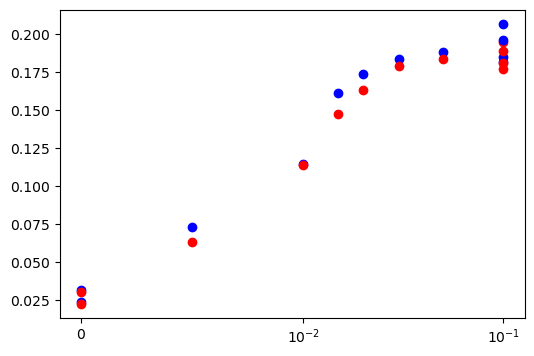

In [289]:
# Split dataframe by Phase

df_br1_trunc_actdeact_grouped = df_br1_trunc_actdeact.groupby("Phase")
df_br2_trunc_actdeact_grouped = df_br2_trunc_actdeact.groupby("Phase")

keys_br1_actdeact = list(df_br1_trunc_actdeact_grouped.groups.keys())
keys_br2_actdeact = list(df_br2_trunc_actdeact_grouped.groups.keys())

keys_add_br1 = []
keys_add_br2 = []


mu_mean_br1_actdeact = []
mu_std_br1_actdeact = []
mu_mean_br2_actdeact = []
mu_std_br2_actdeact = []

rangeme = 20

for key in keys_br1_actdeact:
    df = df_br1_trunc_actdeact_grouped.get_group(key)
    mu_mean_br1_actdeact.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    mu_std_br1_actdeact.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())
    # df = df_br2_trunc_actdeact_grouped.get_group(key)
    # mu_mean_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    # mu_std_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())

    if '_0%' in key:
        keys_add_br1.append(0)
    elif '_10%' in key:
        keys_add_br1.append(0.1)

for key in keys_br2_actdeact:
    df = df_br2_trunc_actdeact_grouped.get_group(key)
    mu_mean_br2_actdeact.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    mu_std_br2_actdeact.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())
    # df = df_br2_trunc_actdeact_grouped.get_group(key)
    # mu_mean_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    # mu_std_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())

    if '_0%' in key:
        keys_add_br2.append(0)
    elif '_10%' in key:
        keys_add_br2.append(0.1)

    

print(mu_mean_br1)
print(mu_std_br1)
print(mu_mean_br2)
print(mu_std_br2)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(keys, mu_mean_br1, 'o', linewidth=2, color="blue", label="Bioreactor 1")
ax.plot(keys, mu_mean_br2, 'o', linewidth=2, color="red", label="Bioreactor 2")
ax.plot(keys_add_br1, mu_mean_br1_actdeact, 'o', linewidth=2, color="blue", label="Bioreactor 1")
ax.plot(keys_add_br2, mu_mean_br2_actdeact, 'o', linewidth=2, color="red", label="Bioreactor 2")

ax.set_xscale('symlog', linthresh=0.01)

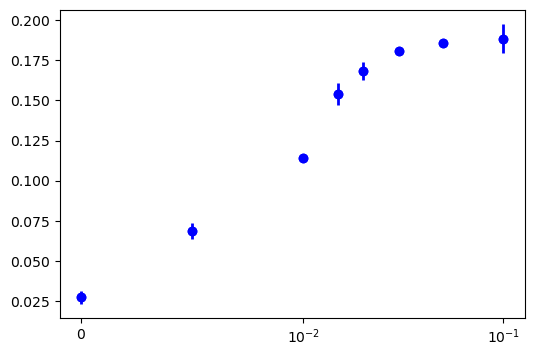

In [290]:
keys_plot = keys + keys + keys_add_br1 + keys_add_br2
mu_plot = mu_mean_br1 + mu_mean_br2 + mu_mean_br1_actdeact + mu_mean_br2_actdeact
mu_plot = np.array(mu_plot)
keys_plot = np.array(keys_plot)

mu_plot = mu_plot[np.argsort(keys_plot)]
keys_plot = keys_plot[np.argsort(keys_plot)]

keys_unique = np.unique(keys_plot)
mu_unique = []
mu_std_unique = []

for key in keys_unique:
    mu_unique.append(mu_plot[keys_plot == key].mean())
    mu_std_unique.append(mu_plot[keys_plot == key].std())


fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(keys_unique, mu_unique, 'o', linewidth=2, color="blue", label="Bioreactor 1")
ax.errorbar(keys_unique, mu_unique, yerr=mu_std_unique, fmt='o', linewidth=2, color="blue", label="Bioreactor 1")
ax.set_xscale('symlog', linthresh=0.01)


In [337]:
from scipy.optimize import curve_fit, root

# Steady State Equations

def opto_ode(t, y, p, I):
    T, R = y
    kon, koff, kbasal, kmax, n, Kd, kdegR = p

    T = max(0, T)

    dTdt = I * kon  * (1-T) - koff * T
    dRdt = kbasal + kmax * (T**n / (Kd**n + T**n)) - kdegR * R

    out = np.array([dTdt, dRdt])
    return out

def opto_ode_ss(pulse, period, p):
    Imax = 1
    guess = np.array([pulse, pulse])
    def f_solve(xinit):
        if pulse > 0:
            sol = solve_ivp(opto_ode, [0, period*pulse], xinit, args=(p, Imax,), atol=1e-6, rtol=1e-6, method="BDF")
            sol = solve_ivp(opto_ode, [period*pulse, period], sol.y[:,-1], args=(p,0), atol=1e-6, rtol=1e-6, method="BDF")
        else:
            sol = solve_ivp(opto_ode, [0, period], xinit, args=(p, 0,), atol=1e-6, rtol=1e-6, method="BDF")

        out = sol.y[:,-1] - xinit[:]
        return out

    rootsol = root(f_solve, guess, options={'xtol': 1e-8, 'maxfev': 1000})

    if not rootsol.success:
        # print("Root finding failed at pulse = ", pulse)
        return 0, 0
    
    if pulse > 0:
        sol_first = solve_ivp(opto_ode, [0, period*pulse], rootsol.x, args=(p, Imax,), atol=1e-8, rtol=1e-8, method="BDF", t_eval=np.linspace(0, period*pulse, 1000))
        sol_second = solve_ivp(opto_ode, [period*pulse, period], sol_first.y[:,-1], args=(p,0), atol=1e-8, rtol=1e-8, method="BDF", t_eval=np.linspace(period*pulse, period, 1000))

        # Average outputs by integrating over the period
        Tss = (np.trapz(sol_first.y[0,:], sol_first.t) + np.trapz(sol_second.y[0,:], sol_second.t)) / period
        Rss = (np.trapz(sol_first.y[1,:], sol_first.t) + np.trapz(sol_second.y[1,:], sol_second.t)) / period
    
    else:
        sol = solve_ivp(opto_ode, [0, period], rootsol.x, args=(p, 0,), atol=1e-8, rtol=1e-8, method="BDF", t_eval=np.linspace(0, period, 1000))
        Tss = np.trapz(sol.y[0,:], sol.t) / period
        Rss = np.trapz(sol.y[1,:], sol.t) / period

    return Tss, Rss



def mu_steady(pulse_arr, kon, koff, kbasal, kmax, Kd, n, kE, KAmp, nAmp):
    # Keep Constant For Now
    kdeg_R, kAmp, kdeg_Amp, kdeg_E, mu_max = 1e5, 1e5, 1e5, 1e5, 1

    period = 100
    
    Tss_arr, Rss_arr, Ampss_arr, Ess_arr, mu_arr = [], [], [], [], []

    for pulse in pulse_arr:
        p_opto = [kon, koff, kbasal, kmax, n, Kd, kdeg_R]
        Tss, Rss = opto_ode_ss(pulse, period, p_opto)
        Ampss = kAmp * Rss / kdeg_Amp
        Ess = (kE * Ampss**nAmp / (KAmp**nAmp + Ampss**nAmp)) / kdeg_E
        mu = mu_max * Ess

        Tss_arr.append(Tss)
        Rss_arr.append(Rss)
        Ampss_arr.append(Ampss)
        Ess_arr.append(Ess)
        mu_arr.append(mu)
    
    return Tss_arr, Rss_arr, Ampss_arr, Ess_arr, mu_arr

def minimize_fun(pars, pulse_arr, mu_unique, info):
    _, _, _, _, mu_arr = mu_steady(pulse_arr, *pars)
    error = np.sum((np.array(mu_arr) - np.array(mu_unique))**2)

    if error < info['error_best']:
        info['error_best'] = error
        info['pars_best'] = pars

    if info['Nfeval']%10 == 0:
        print('Nfeval: ', info['Nfeval'], 'error_best: ', info['error_best'], 'pars_best: ', info['pars_best'], 'error: ', error, 'pars: ', pars)
    info['Nfeval'] += 1
    return np.sum((np.array(mu_arr) - np.array(mu_unique))**2)

def minimize_fun_ls(pars, pulse_arr, mu_unique, info):
    _, _, _, _, mu_arr = mu_steady(pulse_arr, *pars)
    error = np.sum((np.array(mu_arr) - np.array(mu_unique))**2)

    if error < info['error_best']:
        info['error_best'] = error
        info['pars_best'] = pars

    if info['Nfeval']%10 == 0:
        print('Nfeval: ', info['Nfeval'], 'error_best: ', info['error_best'], 'pars_best: ', info['pars_best'], 'error: ', error, 'pars: ', pars)
    info['Nfeval'] += 1
    return np.array(mu_arr) - np.array(mu_unique)

In [294]:
keys_unique

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.03 , 0.05 , 0.1  ])

In [301]:
# Interpolate more values for curve fit

keys_unique_interp = np.array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.03 , 0.05 , 0.08, 0.1  ])
mu_unique_interp = np.interp(keys_unique_interp, keys_unique, mu_unique)

[0.0, 0.6731955082543846, 0.7955504982660156, 0.8433853436711248, 0.8671510612306274, 0.8884796992178172, 0.9014780894125607, 0.9122814254559722]
Nfeval:  0 error_best:  0.00011581577749982395 pars_best:  [9.68252737e-01 2.19921174e-03 6.28506920e+03 1.16596501e+05
 1.07820298e+00 6.30770501e+00 4.97785107e+04 5.20973750e-01
 1.33597703e+00] error:  0.00011581577749982395 pars:  [9.68252737e-01 2.19921174e-03 6.28506920e+03 1.16596501e+05
 1.07820298e+00 6.30770501e+00 4.97785107e+04 5.20973750e-01
 1.33597703e+00]
Nfeval:  10 error_best:  0.00011581211448678997 pars_best:  [9.68236541e-01 2.19921174e-03 6.28560765e+03 1.16599351e+05
 1.07818768e+00 6.30768725e+00 4.97782589e+04 5.20972738e-01
 1.33598144e+00] error:  0.00011581211448678997 pars:  [9.68236541e-01 2.19921174e-03 6.28560765e+03 1.16599351e+05
 1.07818768e+00 6.30768725e+00 4.97782589e+04 5.20972738e-01
 1.33598144e+00]
Nfeval:  20 error_best:  0.00011581211390303977 pars_best:  [9.68236541e-01 2.19921174e-03 6.28560765e+

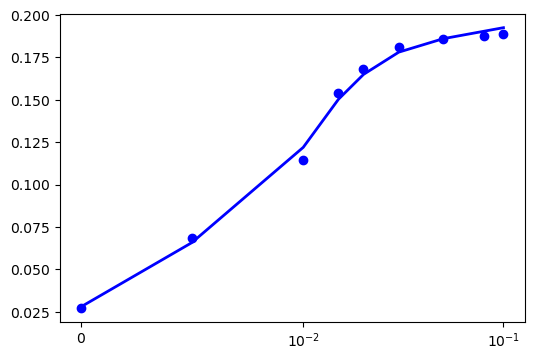

In [343]:
from scipy.optimize import curve_fit, minimize, shgo, basinhopping, least_squares

# Initial Guess
kon = 9.31671021e-01
koff = 2.20344877e-03
kbasal = 5.20591166e+03
kmax = 1.09958539e+05
Kd = 1.05446574e+00
n = 6.40189294e+00
kE = 5.15658015e+04
KAmp = 5.66616619e-01
nAmp = 1.20085989e+00

p0 = [kon, koff, kbasal, kmax, Kd, n, kE, KAmp, nAmp]

# Plot initial guess
I_arr = keys_unique#_interp
Tss_arr, Rss_arr, Ampss_arr, Ess_arr, mu_arr = mu_steady(I_arr, *p0)

print(Tss_arr)
# print(Rss_arr)
# print(Ampss_arr)
# print(Ess_arr)
# print(mu_arr)

# mu_arr = np.array(Ess_arr) * 1.1

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(I_arr, mu_arr, '-', linewidth=2, color="blue", label="Bioreactor 1")
ax.plot(keys_unique_interp, mu_unique_interp, 'o', linewidth=2, color="blue", label="Bioreactor 1")
ax.set_xscale('symlog', linthresh=0.01)

# Fit
def curve_fit_fun(pulse_arr, kon, koff, kbasal, kmax, Kd, n, kE, KAmp, nAmp):
    return mu_steady(pulse_arr, kon, koff, kbasal, kmax, Kd, n, kE, KAmp, nAmp)[4]

# popt, pcov = curve_fit(curve_fit_fun, I_arr, mu_unique_interp, p0=p0, maxfev=100000)
bounds = [(1e-2, 1e1), (1e-5, 1e-1), (1e3, 1e5), (1e4, 1e6), (1e-1, 1e1), (1e-1, 1e1), (1e4, 1e6), (1e-1, 1e1), (1e-1, 1e1)]
info = {'Nfeval':0, 'error_best': 1e10, 'pars_best': np.nan}

p0_ls = res.x
bounds_ls = [(1e-2, 1e-5, 1e3, 1e4, 1e-1, 1e-1, 1e4, 1e-1, 1e-1), (1e1, 1e-1, 1e5, 1e6, 1e1, 1e1, 1e6, 1e1, 1e1)]
x_scale = np.array([1e0, 1e-4, 1e4, 1e5, 1e0, 1e0, 1e5, 1e0, 1e0])
res = least_squares(minimize_fun_ls, x0=p0_ls, args=(I_arr, mu_unique, info), bounds=bounds_ls, max_nfev=100000, xtol=1e-10, ftol=1e-10, gtol=1e-10, x_scale=x_scale)

# res = minimize(minimize_fun, x0=p0, args=(I_arr, mu_unique, info), bounds=bounds) 
# res = minimize(minimize_fun, x0=p0, args=(I_arr, mu_unique, info), bounds=bounds, method='Nelder-Mead', options={'maxiter':100000}) 
# res = shgo(minimize_fun, args=(I_arr, mu_unique, {'Nfeval':0}), bounds=bounds)

# res = basinhopping(minimize_fun, x0=p0, minimizer_kwargs={'args':(I_arr, mu_unique, info), 'bounds':bounds}, T=1e-1, niter=1000, niter_success=100)
# print(res.x)

# Tss_arr, Rss_arr, Ampss_arr, Ess_arr, mu_arr = mu_steady(I_arr, *res.x)

# fig = plt.figure(figsize=(6, 4))
# ax = fig.add_subplot(111)
# ax.plot(I_arr, mu_arr, '-', linewidth=2, color="blue", label="Bioreactor 1")
# ax.plot(keys_unique, mu_unique, 'o', linewidth=2, color="blue", label="Bioreactor 1")
# ax.set_xscale('symlog', linthresh=0.01)

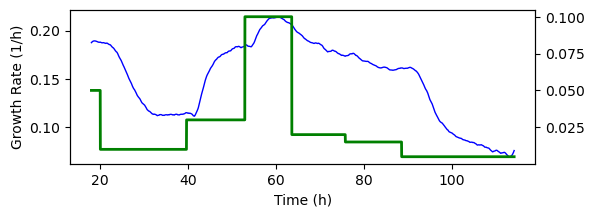

In [344]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)

ax.plot(df_br1_trunc["BatchTime"], df_br1_trunc["GrowthRateSmooth"], linewidth=1, color="blue", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br1_trunc["BatchTime"], df_br1_trunc["Phase"], linewidth=2, color="green", label="Bioreactor 1")

In [345]:
def myODEs(t, x, pfixed, pvar, pulse):
    # Unpack Parameters
    kon, koff, kbasal_base, kmax_base, Kd, n, kE_base, KAmp, nAmp = pfixed
    kdeg_R, kdeg_Amp, kdeg_E = pvar

    kbasal = kbasal_base * kdeg_R / 1e5
    kmax = kmax_base * kdeg_R / 1e5
    kE = kE_base * kdeg_E / 1e5
    kAmp = kdeg_Amp

    global pulse_old, R_ss
    if pulse != pulse_old:
        period = 100
        p = kon, koff, kbasal, kmax, n, Kd, kdeg_R
        _, R_ss = opto_ode_ss(pulse, period, p)
        pulse_old = pulse

    # Unpack Variables
    R, Amp, E = x

    # Equations
    dRdt = (R_ss - R) * kdeg_R
    dAmpdt = kAmp * R - kdeg_Amp * Amp
    dEdt = kE * Amp**nAmp / (KAmp**nAmp + Amp**nAmp) - kdeg_E * E

    return np.array([dRdt, dAmpdt, dEdt])

0.3682839360648241
([0.9125964850113342], [0.36983989152886454], [0.36983989152886454], [0.19290127746601335], [0.19290127746601335])


In [347]:
s = df_br1_trunc["Phase"]
# time_array_fit = [df_br1_trunc["BatchTime"].iloc[0]]
time_array_fit = []
time_array_fit = np.append(time_array_fit, df_br1_trunc["BatchTime"][s[s.diff() != 0].index.tolist()])
time_array_fit = np.append(time_array_fit, df_br1_trunc["BatchTime"].iloc[-1])

# pulse_array_fit = [df_br1_trunc["Phase"].iloc[0]]
pulse_array_fit = []
pulse_array_fit = np.append(pulse_array_fit, df_br1_trunc["Phase"][s[s.diff() != 0].index.tolist()])
# pulse_array_fit = np.append(pulse_array_fit, df_br1_trunc["Phase"].iloc[-1])

print(time_array_fit)
print(pulse_array_fit)
print(mu_steady(pulse_array_fit, *res.x)[-1])

[ 18.01666667  20.03333333  39.63333333  52.9         63.56666667
  75.73333333  88.53333333 114.11666667]
[0.05  0.01  0.03  0.1   0.02  0.015 0.005]
[0.18610850129915832, 0.12181325364799653, 0.17823055562575918, 0.19290127746601335, 0.16508835579822118, 0.1503694672309309, 0.06588342295653785]


In [352]:
mu_steady([pulse_array_fit[0]], *res.x)
pulse = 0.1
period = 100
kdegR = 1e5
p = kon, koff, kbasal, kmax, n, Kd, kdegR
global pulse_old, R_ss
_, R_ss = opto_ode_ss(pulse, period, p)
pulse_old = pulse

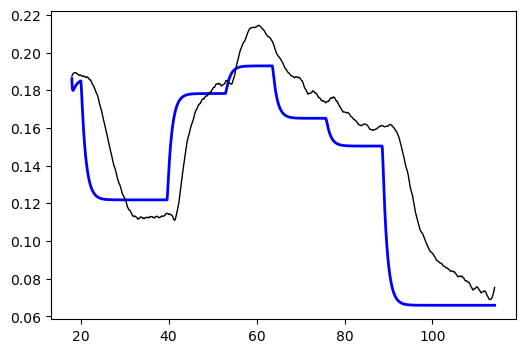

In [353]:
from tqdm import tqdm

time_array_pred = []
mu_array_pred = []

x0 = np.array(mu_steady([pulse_array_fit[0]], *res.x)).flatten()[-3:]

kdeg_R = 1e3
kdeg_Amp = 1e1
kdeg_E = 1e0

pvar = [kdeg_R, kdeg_Amp, kdeg_E]

for i in range(len(time_array_fit)-1):
    pulse = pulse_array_fit[i]

    # print(pulse)
    # print(pulse_old)
    # print(R_ss)
    # print('====================')

    tspan = [time_array_fit[i], time_array_fit[i+1]]
    t_eval = np.linspace(tspan[0], tspan[1], 1000)
    pfixed = res.x
    
    sol = solve_ivp(myODEs, tspan, x0, method="BDF", t_eval=t_eval, args=(pfixed, pvar, pulse), rtol=1e-6, atol=1e-8)
    x0 = sol.y[:,-1]

    time_array_pred = np.append(time_array_pred, sol.t)
    mu_array_pred = np.append(mu_array_pred, sol.y[-1,:])

time_array_pred = np.array(time_array_pred)
mu_array_pred = np.array(mu_array_pred)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(time_array_pred, mu_array_pred, '-', linewidth=2, color="blue", label="Bioreactor 1")
ax.plot(df_br1_trunc["BatchTime"], df_br1_trunc["GrowthRateSmooth"], linewidth=1, color="black", label="Bioreactor 1")

In [354]:
print(pulse_array_fit)
print(mu_steady(pulse_array_fit, *res.x)[-1])
print('====================')
bloopy = np.sort(pulse_array_fit)
print(bloopy)
print(mu_steady(bloopy, *res.x)[-1])
print('====================')
print(I_arr)
print(mu_unique)

[0.05  0.01  0.03  0.1   0.02  0.015 0.005]
[0.18610850129915832, 0.12181325364799653, 0.17823055562575918, 0.19290127746601335, 0.16508835579822118, 0.1503694672309309, 0.06588342295653785]
[0.005 0.01  0.015 0.02  0.03  0.05  0.1  ]
[0.06588342295653785, 0.12181325364799653, 0.1503694672309309, 0.16508835579822118, 0.17823055562575918, 0.18610850129915832, 0.19290127746601335]
[0.    0.005 0.01  0.015 0.02  0.03  0.05  0.1  ]
[0.027333790058641415, 0.06848180904447033, 0.11429537036088283, 0.15426303121705404, 0.1683217845813016, 0.18105721065011443, 0.1858510728345331, 0.18858913590912657]


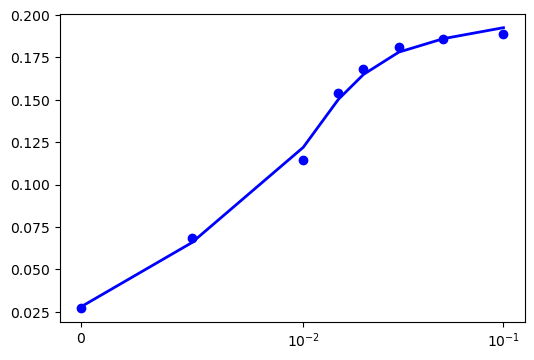

In [355]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(I_arr, mu_arr, '-', linewidth=2, color="blue", label="Bioreactor 1")
ax.plot(keys_unique, mu_unique, 'o', linewidth=2, color="blue", label="Bioreactor 1")
ax.set_xscale('symlog', linthresh=0.01)